#**Importing Dependencies and the trained model**

In [26]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
from tensorflow.python.ops.math_ops import xdivy
from tensorflow.keras.layers import *
import IPython

#Order of emotion in one_hot: Anger, Disgust, Fear, Happy, Neutral, Sad
emotions = np.array(['ANG','DIS','FEA','HAP','NEU','SAD'])

In [10]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [11]:
cd '/content/gdrive/My Drive/Colab Notebooks/Voice_CNN/'

/content/gdrive/My Drive/Colab Notebooks/Voice_CNN


In [12]:
audiolength = np.load('audiolength.npy')
[min_a, max_a,max_length,entry] = np.load('stats.npy')

In [60]:
voicecnn = tf.keras.models.load_model('/content/gdrive/MyDrive/Colab Notebooks/Voice_CNN/6_2_2023_model')

In [61]:
voicecnn.summary()

Model: "cnn-1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 79, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 256, 79, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 39, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 39, 64)       32832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 19, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 19, 64)        65600 

# **Recording Audio from microphone**

In [19]:
cd '/content/gdrive/My Drive/Colab Notebooks/Voice_CNN/Audio_tests'

/content/gdrive/My Drive/Colab Notebooks/Voice_CNN/Audio_tests


In [20]:
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode
from io import BytesIO
!pip -q install pydub
from pydub import AudioSegment

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec):
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1000))
  b = b64decode(s.split(',')[1])
  with open('audio_test.wav','wb') as f:
    f.write(b)
  return 'audio_test.wav'

In [21]:
audiooutput = record(10)


<IPython.core.display.Javascript object>

In [27]:
IPython.display.Audio('audio_test.wav')

# **Processing the audio**

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


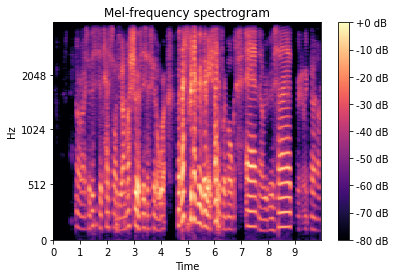

In [23]:
import librosa
import librosa.display

audio_data, sr = librosa.load('audio_test.wav', sr= 8000, mono=True)
melspectrum = librosa.feature.melspectrogram(y=audio_data, sr=sr, hop_length= 512, window='hann', n_mels=256)
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(melspectrum, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')
plt.show()

In [31]:
melspectrum.shape

(256, 156)

In [38]:
np.zeros([256,1]).shape

(256, 1)

In [ ]:
melspectrum = (np.log(np.array(melspectrum))-min_a)/(max_a-min_a)
melspectrum = np.concatenate((melspectrum,np.zeros([256,max_length-melspectrum.shape[1]])), axis = 1)
melspectrum = np.nan_to_num(melspectrum, copy=False, nan=0.0, posinf=0.0, neginf=0.0)

In [52]:
melspectrum.shape

(256, 1)

# **Processing the results**

In [83]:
predicted_emotions = np.zeros([6,melspectrum.shape[1]])
slices = np.empty([melspectrum.shape[1],256,int(max_length)])
for i in range(melspectrum.shape[1]):
  if (i+1)<max_length:
    section = np.concatenate((melspectrum[0:melspectrum.shape[0],:(i+1)],np.zeros([256,int(max_length)-(i+1)])), axis = 1)
  else:
    section = melspectrum[0:melspectrum.shape[0],(i-int(max_length)+1):(i+1)]
  slices[i] = section

In [84]:
slices.shape

(156, 256, 79)

In [89]:
output = voicecnn.predict(slices,batch_size = 32)

5/5 [==============================] - 2s 392ms/step


In [92]:
output

array([[9.6853718e-04, 1.7011438e-02, 4.4950959e-03, 2.6219552e-03,
        4.9440735e-03, 9.6995890e-01],
       [9.6852944e-04, 1.7011398e-02, 4.4950820e-03, 2.6219257e-03,
        4.9440148e-03, 9.6995902e-01],
       [9.6852402e-04, 1.7011367e-02, 4.4950699e-03, 2.6218996e-03,
        4.9439757e-03, 9.6995914e-01],
       [9.6852356e-04, 1.7011376e-02, 4.4950699e-03, 2.6218996e-03,
        4.9439757e-03, 9.6995914e-01],
       [9.6852274e-04, 1.7011354e-02, 4.4950680e-03, 2.6218973e-03,
        4.9439711e-03, 9.6995926e-01],
       [9.6850237e-04, 1.7011190e-02, 4.4949986e-03, 2.6218533e-03,
        4.9438719e-03, 9.6995962e-01],
       [9.6849148e-04, 1.7011169e-02, 4.4949637e-03, 2.6218265e-03,
        4.9438043e-03, 9.6995986e-01],
       [9.6846733e-04, 1.7011045e-02, 4.4949027e-03, 2.6217573e-03,
        4.9436432e-03, 9.6996015e-01],
       [9.6846954e-04, 1.7011093e-02, 4.4949115e-03, 2.6217625e-03,
        4.9436600e-03, 9.6996015e-01],
       [9.6845726e-04, 1.7010998e-02,

In [106]:
output = output.swapaxes(0,1)

In [107]:
output

array([[9.6853718e-04, 9.6852944e-04, 9.6852402e-04, 9.6852356e-04,
        9.6852274e-04, 9.6850237e-04, 9.6849148e-04, 9.6846733e-04,
        9.6846954e-04, 9.6845726e-04, 9.6835510e-04, 9.6834078e-04,
        9.6625410e-04, 3.3682215e-03, 5.4663739e-18, 2.4801349e-19,
        4.6514067e-19, 1.0629591e-25, 1.2349608e-25, 2.7675701e-25,
        1.2626944e-26, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e

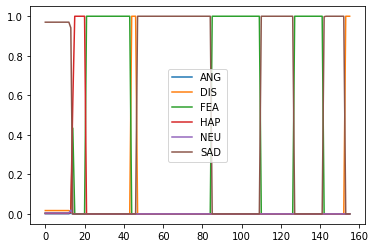

In [109]:
for i in range(len(emotions)):
  plt.plot(output[i], label = emotions[i])
plt.legend()
plt.show()